In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml
import seaborn as sns

/tmp/ipykernel_4387/4026356266.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
run = 'final_CC'
target = 'NEE_VUT_REF'

DATA_DIR = Path('data') / 'processed' / 'carbonsense'
META_DIR = Path('data') / 'meta'
RUN_DIR = Path('runs') / run
CONFIG_PATH = RUN_DIR / 'config.yml'

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

TRAIN_SITES = config['data']['train_sites']
VAL_SITES = config['data']['val_sites']
TEST_SITES = config['data']['test_sites']

In [3]:
site_meta = pd.read_csv(META_DIR / 'processed_site_meta.csv')

In [4]:
# XGBoost output
XGB_DIR = RUN_DIR / 'xgb'
df_xgb = pd.read_csv(XGB_DIR / 'results_xgb.csv')

In [5]:
# EcoPerceiver output
df_eco = None
seeds = sorted([d for d in os.listdir(RUN_DIR) if 'seed' in d])
for seed in seeds:
    
    files = [f for f in os.listdir(RUN_DIR / seed) if 'results' in f]
    if len(files) == 0:
        print(f'No results file found in {seed}, skipping...')
        continue
    elif len(files) > 1:
        print(f'Multiple results files found in {seed}, skipping...')
        continue
    results_file = files[0]

    df_seed = pd.read_csv(RUN_DIR / seed / results_file)
    column = f'Eco_{seed.split("_")[1]}'
    df_seed = df_seed.rename(columns={'Inferred': column})
    if df_eco is None:
        df_eco = df_seed
    else:
        df_eco[column] = df_seed[column]


In [6]:
df_xgb_reduced = df_xgb[df_xgb[target].notna()]
df_eco_reduced = df_eco[df_eco['Eco_0'].notna()]

In [47]:
# NSE, RMSE stats
def nse(targets, preds):
    return 1-(np.sum((targets-preds)**2)/np.sum((targets-np.mean(targets))**2))

def rmse(targets, preds):
    return (np.sum((targets-preds)**2)/len(targets)) ** 0.5

def create_metric_dict(metric):
    site_igbp_map = {}
    for site in TEST_SITES:
        site_igbp = site_meta[site_meta['SITE_ID'] == site]['IGBP'].values[0]
        if site_igbp in site_igbp_map:
            site_igbp_map[site_igbp].append(site)
        else:
            site_igbp_map[site_igbp] = [site]
    
    metrics = {}
    for igbp, sites in site_igbp_map.items():
        metrics[igbp] = {}
        for df, label in zip([df_xgb_reduced, df_eco_reduced], ['XGBoost', 'EcoPerceiver']):
            igbp_df = df[df['SITE_ID'].isin(sites)]
            values = []
            cols = [col for col in igbp_df.columns if col not in ['SITE_ID', 'timestamp', target]]
            for col in cols:
                values.append(metric(igbp_df[target].values, igbp_df[col].values))
            metrics[igbp][label] = np.array(values)
    return metrics

rmse_stats = create_metric_dict(rmse)
nse_stats = create_metric_dict(nse)

In [16]:
for k, v in nse_stats.items():
    print(k)
    print(f"\tXGBoost:\t{v['XGBoost'].mean()}")
    print(f"\tEcoPerceiver:\t{v['EcoPerceiver'].mean()}")

WET
	XGBoost:	0.4530223010208629
	EcoPerceiver:	0.4136567650431447
DNF
	XGBoost:	0.2803020406549875
	EcoPerceiver:	0.43361858311314005
WSA
	XGBoost:	0.6132433788973429
	EcoPerceiver:	0.6267389071107391
EBF
	XGBoost:	0.7966155199968368
	EcoPerceiver:	0.8219905713707936
ENF
	XGBoost:	0.7765120554913525
	EcoPerceiver:	0.7694271501606719
DBF
	XGBoost:	0.7250006943726467
	EcoPerceiver:	0.7547098371524881
CRO
	XGBoost:	0.8065822813652049
	EcoPerceiver:	0.8482139722171592
MF
	XGBoost:	0.755886007035328
	EcoPerceiver:	0.771657130661678
GRA
	XGBoost:	0.7460643886675512
	EcoPerceiver:	0.7966823094860767
OSH
	XGBoost:	0.5450858511575966
	EcoPerceiver:	0.6060082125638262
CVM
	XGBoost:	0.527684597235235
	EcoPerceiver:	0.5762584912246662
CSH
	XGBoost:	0.7509910154865028
	EcoPerceiver:	0.7669749076044406
SAV
	XGBoost:	0.5802026968200411
	EcoPerceiver:	0.7367623590940429
SNO
	XGBoost:	-0.036951569763622384
	EcoPerceiver:	0.28978755491098296
WAT
	XGBoost:	-11.052444162431913
	EcoPerceiver:	-14.40098004

In [48]:
ig = sorted(rmse_stats.keys())
for g in ig:
    xnse = nse_stats[g]['XGBoost'].mean()
    ense = nse_stats[g]['EcoPerceiver'].mean()

    xrmse = rmse_stats[g]['XGBoost'].mean()
    ermse = rmse_stats[g]['EcoPerceiver'].mean()

    if xnse > ense:
        print(f'{g}\t& \\textbf{{{xnse:.4f}}}\t & \\textbf{{{xrmse:.4f}}}\t & {ense:.4f}\t & {ermse:.4f}\t \\\\')
    else:
        print(f'{g}\t& {xnse:.4f}\t & {xrmse:.4f}\t & \\textbf{{{ense:.4f}}}\t & \\textbf{{{ermse:.4f}}}\t \\\\')

CRO	& 0.8066	 & 3.2381	 & \textbf{0.8482}	 & \textbf{2.8677}	 \\
CSH	& 0.7510	 & 1.5224	 & \textbf{0.7670}	 & \textbf{1.4709}	 \\
CVM	& 0.5277	 & 5.5157	 & \textbf{0.5763}	 & \textbf{5.2236}	 \\
DBF	& 0.7250	 & 4.0959	 & \textbf{0.7547}	 & \textbf{3.8678}	 \\
DNF	& 0.2803	 & 4.0974	 & \textbf{0.4336}	 & \textbf{3.6322}	 \\
EBF	& 0.7966	 & 4.6050	 & \textbf{0.8220}	 & \textbf{4.3070}	 \\
ENF	& \textbf{0.7765}	 & \textbf{2.8141}	 & 0.7694	 & 2.8579	 \\
GRA	& 0.7461	 & 3.2487	 & \textbf{0.7967}	 & \textbf{2.9059}	 \\
MF	& 0.7559	 & 3.8633	 & \textbf{0.7717}	 & \textbf{3.7361}	 \\
OSH	& 0.5451	 & 1.8796	 & \textbf{0.6060}	 & \textbf{1.7475}	 \\
SAV	& 0.5802	 & 1.6514	 & \textbf{0.7368}	 & \textbf{1.3070}	 \\
SNO	& -0.0370	 & 1.4291	 & \textbf{0.2898}	 & \textbf{1.1816}	 \\
WAT	& \textbf{-11.0524}	 & \textbf{3.1838}	 & -14.4010	 & 3.5802	 \\
WET	& \textbf{0.4530}	 & \textbf{2.2073}	 & 0.4137	 & 2.2830	 \\
WSA	& 0.6132	 & 2.5153	 & \textbf{0.6267}	 & \textbf{2.4706}	 \\


<Axes: >

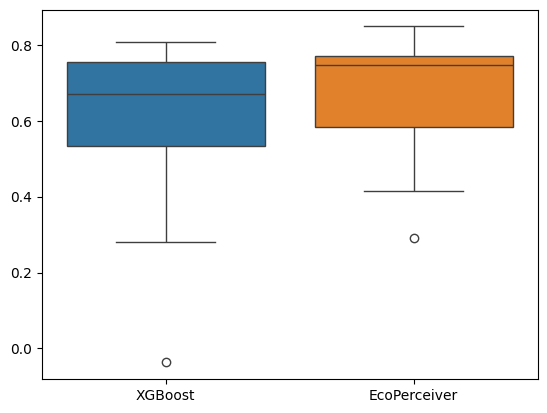

In [26]:
total_xnse = []
total_ense = []
total_xrmse = []
total_ermse = []
for g in ig:
    if g != 'WAT':
        total_xnse.append(nse_stats[g]['XGBoost'].mean())
        total_ense.append(nse_stats[g]['EcoPerceiver'].mean())

        total_xrmse.append(rmse_stats[g]['XGBoost'].mean())
        total_ermse.append(rmse_stats[g]['EcoPerceiver'].mean())

total_nse_df = pd.DataFrame({'XGBoost': total_xnse, 'EcoPerceiver': total_ense})
total_rmse_df = pd.DataFrame({'XGBoost': total_xrmse, 'EcoPerceiver': total_ermse})

sns.boxplot(data=total_nse_df)

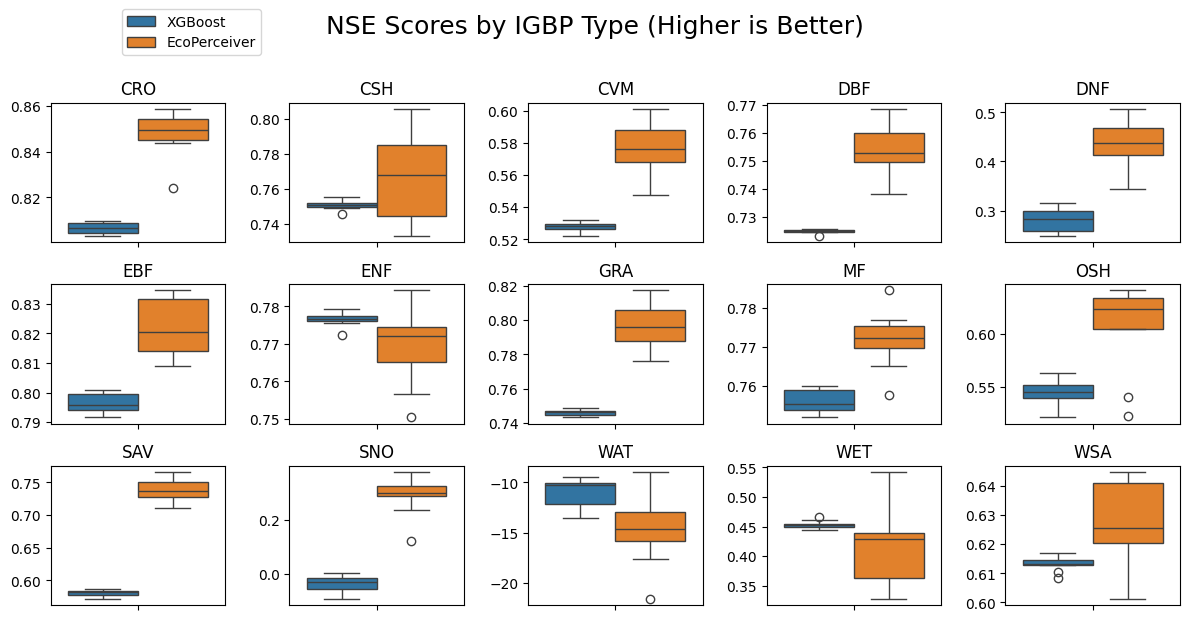

In [71]:
igbp_list = []
model_list = []
value_list = []
for igbp, stats in nse_stats.items():
    for model, values in stats.items():
        for value in values:
            igbp_list.append(igbp)
            model_list.append(model)
            value_list.append(value)
df_nse = pd.DataFrame({'IGBP': igbp_list, 'Model': model_list, 'Score': value_list})
igbp_types = sorted(list(set(igbp_list)))
fig, axes = plt.subplots(3, 5, figsize=(12,6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.title('NSE')

for y in range(3):
    for x in range(5):
        i = 5*y + x
        e = igbp_types[i]
        df = df_nse[df_nse['IGBP'] == e]
        sns.boxplot(data=df, hue='Model', y='Score', ax=axes[y,x])
        axes[y, x].set_ylabel('')
        axes[y, x].set_title(e)

handles, labels = axes[0, 0].get_legend_handles_labels()

for y in range(3):
    for x in range(5):
        axes[y, x].get_legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.1, 0.99), ncol=1)

# Add a title for the figure
fig.suptitle('NSE Scores by IGBP Type (Higher is Better)', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('nse_scores.png', bbox_inches='tight')
plt.show()
#sns.boxplot(data=df_nse, x='IGBP', y='Score', hue='Model')

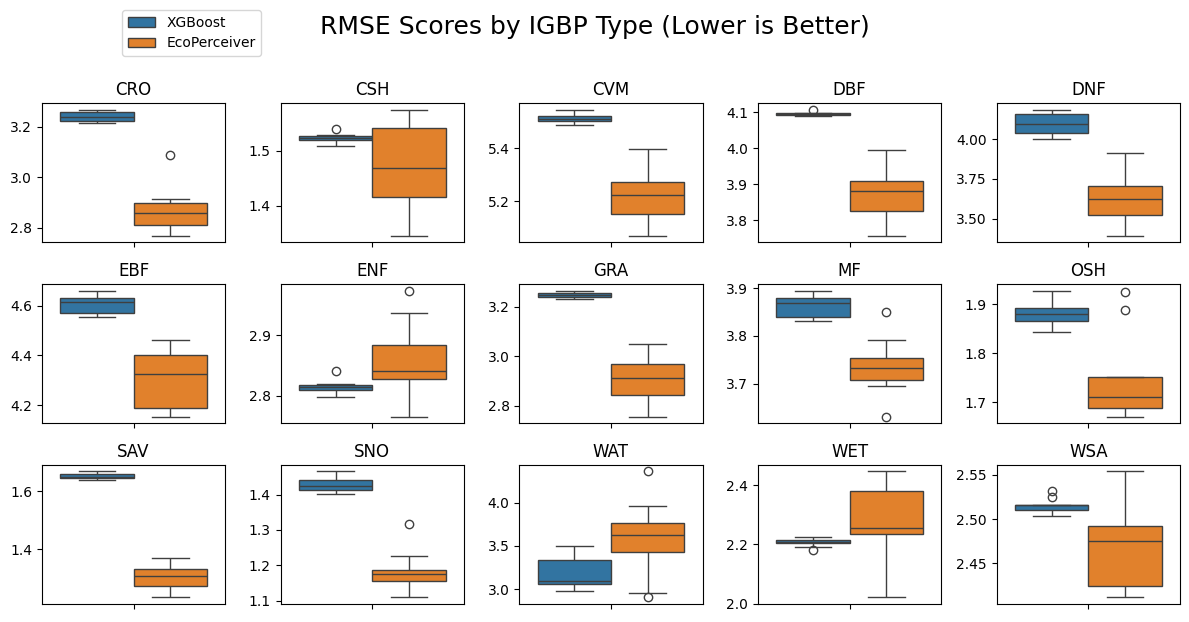

In [73]:
igbp_list = []
model_list = []
value_list = []
for igbp, stats in rmse_stats.items():
    for model, values in stats.items():
        for value in values:
            igbp_list.append(igbp)
            model_list.append(model)
            value_list.append(value)
df_rmse = pd.DataFrame({'IGBP': igbp_list, 'Model': model_list, 'Score': value_list})
igbp_types = sorted(list(set(igbp_list)))
fig, axes = plt.subplots(3, 5, figsize=(12,6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.title('RMSE')

for y in range(3):
    for x in range(5):
        i = 5*y + x
        e = igbp_types[i]
        df = df_rmse[df_rmse['IGBP'] == e]
        sns.boxplot(data=df, hue='Model', y='Score', ax=axes[y,x])
        axes[y, x].set_ylabel('')
        axes[y, x].set_title(e)

handles, labels = axes[0, 0].get_legend_handles_labels()

for y in range(3):
    for x in range(5):
        axes[y, x].get_legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.1, 0.99), ncol=1)

# Add a title for the figure
fig.suptitle('RMSE Scores by IGBP Type (Lower is Better)', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('rmse_scores.png', bbox_inches='tight')
plt.show()
#sns.boxplot(data=df_nse, x='IGBP', y='Score', hue='Model')

In [3]:
site_type_distribution = pd.read_csv(RUN_DIR / 'site_type_distribution.csv')
site_meta = pd.read_csv('processed_site_meta.csv')
xgb_inference_df = pd.read_csv(RUN_DIR / 'xgb_inference.csv').sort_values(by=['SITE_ID', 'timestamp']).reset_index(drop=True)
xgb_inference_df['timestamp'] = pd.to_datetime(xgb_inference_df['timestamp'])
deep_inference_df = pd.read_csv(RUN_DIR / 'deep_inference.csv').sort_values(by=['SITE_ID', 'timestamp']).reset_index(drop=True)
inference_df = xgb_inference_df
inference_df.rename(columns={'Inferred': 'XGBoost'}, inplace=True)
inference_df['Deep Model'] = deep_inference_df['Inferred']
inference_df = inference_df[['SITE_ID', 'timestamp', 'NEE_VUT_REF', 'XGBoost', 'Deep Model']]

/tmp/ipykernel_4387/1679294750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt['Model'] = 'Ground Truth'


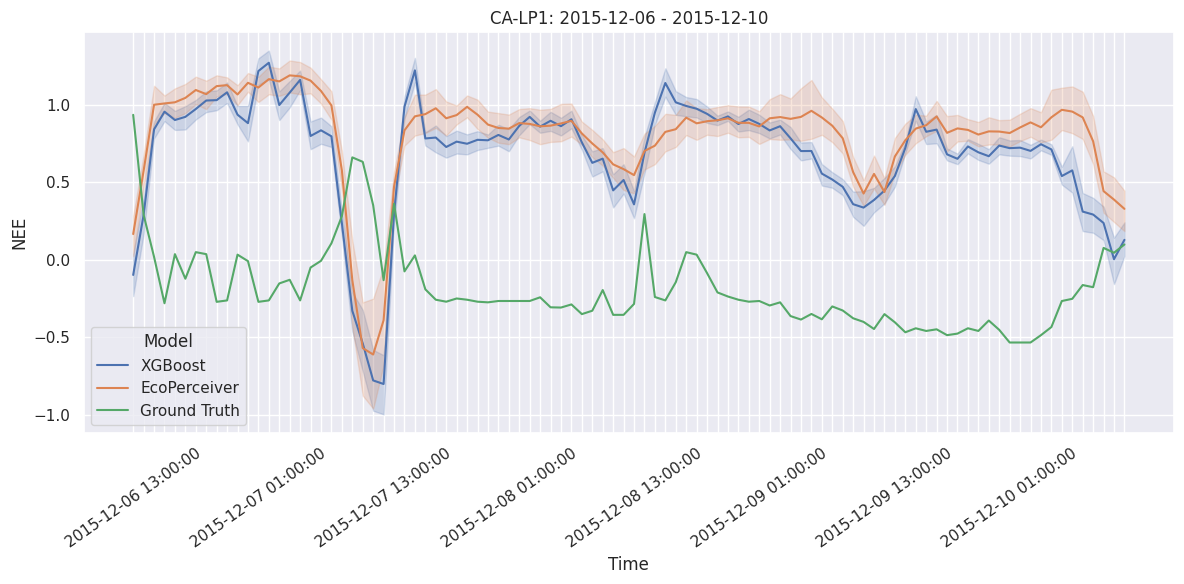

In [142]:
def compare_outputs(site, df1, df2, num_days):
    df1_red = df1[df1['SITE_ID'] == site]
    df2_red = df2[df2['SITE_ID'] == site]

    df_gt = df1_red[['timestamp', 'NEE_VUT_REF']]
    df_gt['Model'] = 'Ground Truth'
    
    num_samples = len(df1_red)
    for i in range(50):
        start = np.random.randint(0, num_samples - num_days*24)
        sub_df = df_gt[start:start+num_days*24]
        if sub_df['NEE_VUT_REF'].isna().sum() == 0:
            break
    else:
        print('could not find any viable windows')
    sub_dfs = []
    df1_red = df1_red[start:start+num_days*24]
    df2_red = df2_red[start:start+num_days*24]
    for c in df1_red.columns[3:]:
        df_temp = df1_red[['timestamp', c]]
        df_temp = df_temp.rename(columns={c: 'NEE_VUT_REF'})
        df_temp['Model'] = 'XGBoost'
        sub_dfs.append(df_temp)
    for c in df2_red.columns[3:]:
        df_temp = df2_red[['timestamp', c]]
        df_temp = df_temp.rename(columns={c: 'NEE_VUT_REF'})
        df_temp['Model'] = 'EcoPerceiver'
        sub_dfs.append(df_temp)
    sub_dfs.append(sub_df)

    final_df = pd.concat(sub_dfs, axis=0)
    sns.set(rc={"figure.figsize":(12, 6)})
    ax = sns.lineplot(data=final_df, x='timestamp', y='NEE_VUT_REF', hue='Model')
    plt.ylabel("NEE")
    plt.xlabel("Time")
    plt.title(f"{site}: {sub_df.iloc[0]['timestamp'][:-9]} - {sub_df.iloc[-1]['timestamp'][:-9]}")
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        if i % 12 != 0:
            label.set_visible(False)
    ax.tick_params(axis='x', rotation=35)
    plt.tight_layout()
    plt.savefig('qualitative.png')


compare_outputs('CA-LP1', df_xgb, df_eco, 4)